In [106]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np
import matplotlib.cm as cm
import matplotlib
import matplotlib as mpl

plt.rcParams['figure.dpi'] = 400

def update_panel_label(df):
    panel = []
    for i in df["Sera pool"]:
        if "BTI_BA.1" in i:
            panel.append("BA.1 BTI")
        elif "BTI_BA.4/5" in i:
            panel.append("BA.4/5 BTI")
        elif "BTI_BA.2.12.1" in i:
            panel.append("BA.2.12.1 BTI")
        elif "BTI_Delta" in i:
            panel.append("Delta BTI")
        elif "Conv_WT" in i:
            panel.append("WT Conv")
        elif "Conv_Delta" in i:
            panel.append("Delta Conv")
        elif "Boost" in i:
            if "Bi" in i:
                panel.append("Bi-valent Boost")
            else:
                panel.append("Boost")
        elif "Vac" in i:
            panel.append("Vaccine")
        else:
            panel.append("else")
    return(panel)

In [107]:
const_df = pd.read_csv('../Data/Supp_TableS4_Construct_Summary.csv')
parent_voc_map = dict(zip(const_df['Name'], const_df['Parent VoC']))

In [108]:
### NEUTRALIZATION DATA ###
neut_df = pd.read_excel('../Data/Supp_TableS7_Neutralization_Data.xlsx', sheet_name='ID50 titers (Pool)')

neut_df = neut_df.melt('Sera pool',var_name = "Name", value_name = "ID50")
neut_df = neut_df.replace({"<20" : 10})
neut_df['ID50'] = neut_df['ID50'].astype(float)
neut_df = neut_df.dropna()
neut_df.head()

,Sera pool,Name,ID50
0,Conv_Delta,B.1,17278.0
1,Conv_WT-1,B.1,9294.0
2,Conv_WT-2,B.1,1788.0
3,Conv_WT-3,B.1,236.0
4,Vac_Mod-1,B.1,1691.0


In [109]:
## Fold reduction per pool for each variant ##
dfs = []
for r in neut_df["Name"].unique().tolist():
    if r == "SARS1":
        continue
        
    variant_df = neut_df[neut_df["Name"] == r].copy()
    base_voc = parent_voc_map[r]

    base_df   = neut_df[neut_df["Name"] == base_voc].copy()
    df_paired = base_df.merge(variant_df, on="Sera pool", how="inner", suffixes=("_base", "_variant"))
    dfs.append(df_paired)

fr_df = pd.concat(dfs, ignore_index=True)
fr_df["Fold Reduction"] = fr_df["ID50_base"] / fr_df["ID50_variant"]
fr_df = fr_df[["Name_variant", "Name_base", "ID50_base", "ID50_variant", "Fold Reduction", "Sera pool"]]
fr_df["panel"] = update_panel_label(fr_df)
fr_df = fr_df.dropna(axis = 0, how = 'any')

In [110]:
## Average reduction per panel per variant ##
panel_geomean   = fr_df.groupby(["Name_variant", "Name_base", "panel"]).agg({'Fold Reduction':stats.gmean, 
                                                              }).reset_index()
variant_geomean = panel_geomean.groupby(["Name_variant", "Name_base"]).agg({'Fold Reduction':stats.gmean}).reset_index()
variant_geomean = variant_geomean.rename(columns = {"Name_variant" :"Name", "Name_base": "Base VoC"})
variant_geomean

,Name,Base VoC,Fold Reduction
0,Alpha,B.1,1.527129
1,B.1,B.1,1.000000
2,B.1-10a,B.1,3.027864
3,B.1-10b,B.1,3.489413
4,B.1-10c,B.1,2.849715
...,...,...,...
81,XBB-8b,XBB,3.622835
82,XBB-9a,XBB,3.901543
83,XBB-9b,XBB,3.691332
84,XBB.1,XBB,0.929276


In [111]:
### INFECTIVITY DATA ###
inf_df = pd.read_excel("../Data/Supp_TableS5_Infectivity_Data.xlsx", header = [0,1])
inf_df = inf_df.loc[:, inf_df.columns.get_level_values(0).str.contains('Infectivity relative to base VoC|Name|Base VoC')].copy()
inf_df = inf_df.loc[:, inf_df.columns.get_level_values(1).str.contains('avg|level_1')].copy()
inf_df.columns = inf_df.columns.droplevel(level=1)
inf_df = inf_df.dropna()
inf_df = inf_df.groupby(["Name", "Base VoC"]).mean().reset_index()
inf_df = inf_df[inf_df.Name != inf_df['Base VoC']]

inf_df

,Name,Base VoC,Infectivity relative to base VoC
0,Alpha,B.1,2.348805
2,B.1-10a,B.1,0.750382
3,B.1-10b,B.1,0.806680
4,B.1-10c,B.1,0.186404
5,B.1-10d,B.1,0.017567
...,...,...,...
100,XBB-8b,XBB,0.402522
101,XBB-9a,XBB,0.213939
102,XBB-9b,XBB,0.671821
103,XBB.1,XBB,0.830081


In [113]:
df_fin = variant_geomean.merge(inf_df, on = ["Name", 'Base VoC'], how = 'inner')
df_fin['label'] = ['des' if '-' in n else 'const' for n in df_fin.Name]
df_fin

,Name,Base VoC,Fold Reduction,Infectivity relative to base VoC,label
0,Alpha,B.1,1.527129,2.348805,const
1,B.1-10a,B.1,3.027864,0.750382,des
2,B.1-10b,B.1,3.489413,0.806680,des
3,B.1-10c,B.1,2.849715,0.186404,des
4,B.1-2a,B.1,1.169592,0.893204,des
...,...,...,...,...,...
75,XBB-8a,XBB,2.859959,0.323892,des
76,XBB-8b,XBB,3.622835,0.402522,des
77,XBB-9a,XBB,3.901543,0.213939,des
78,XBB-9b,XBB,3.691332,0.671821,des


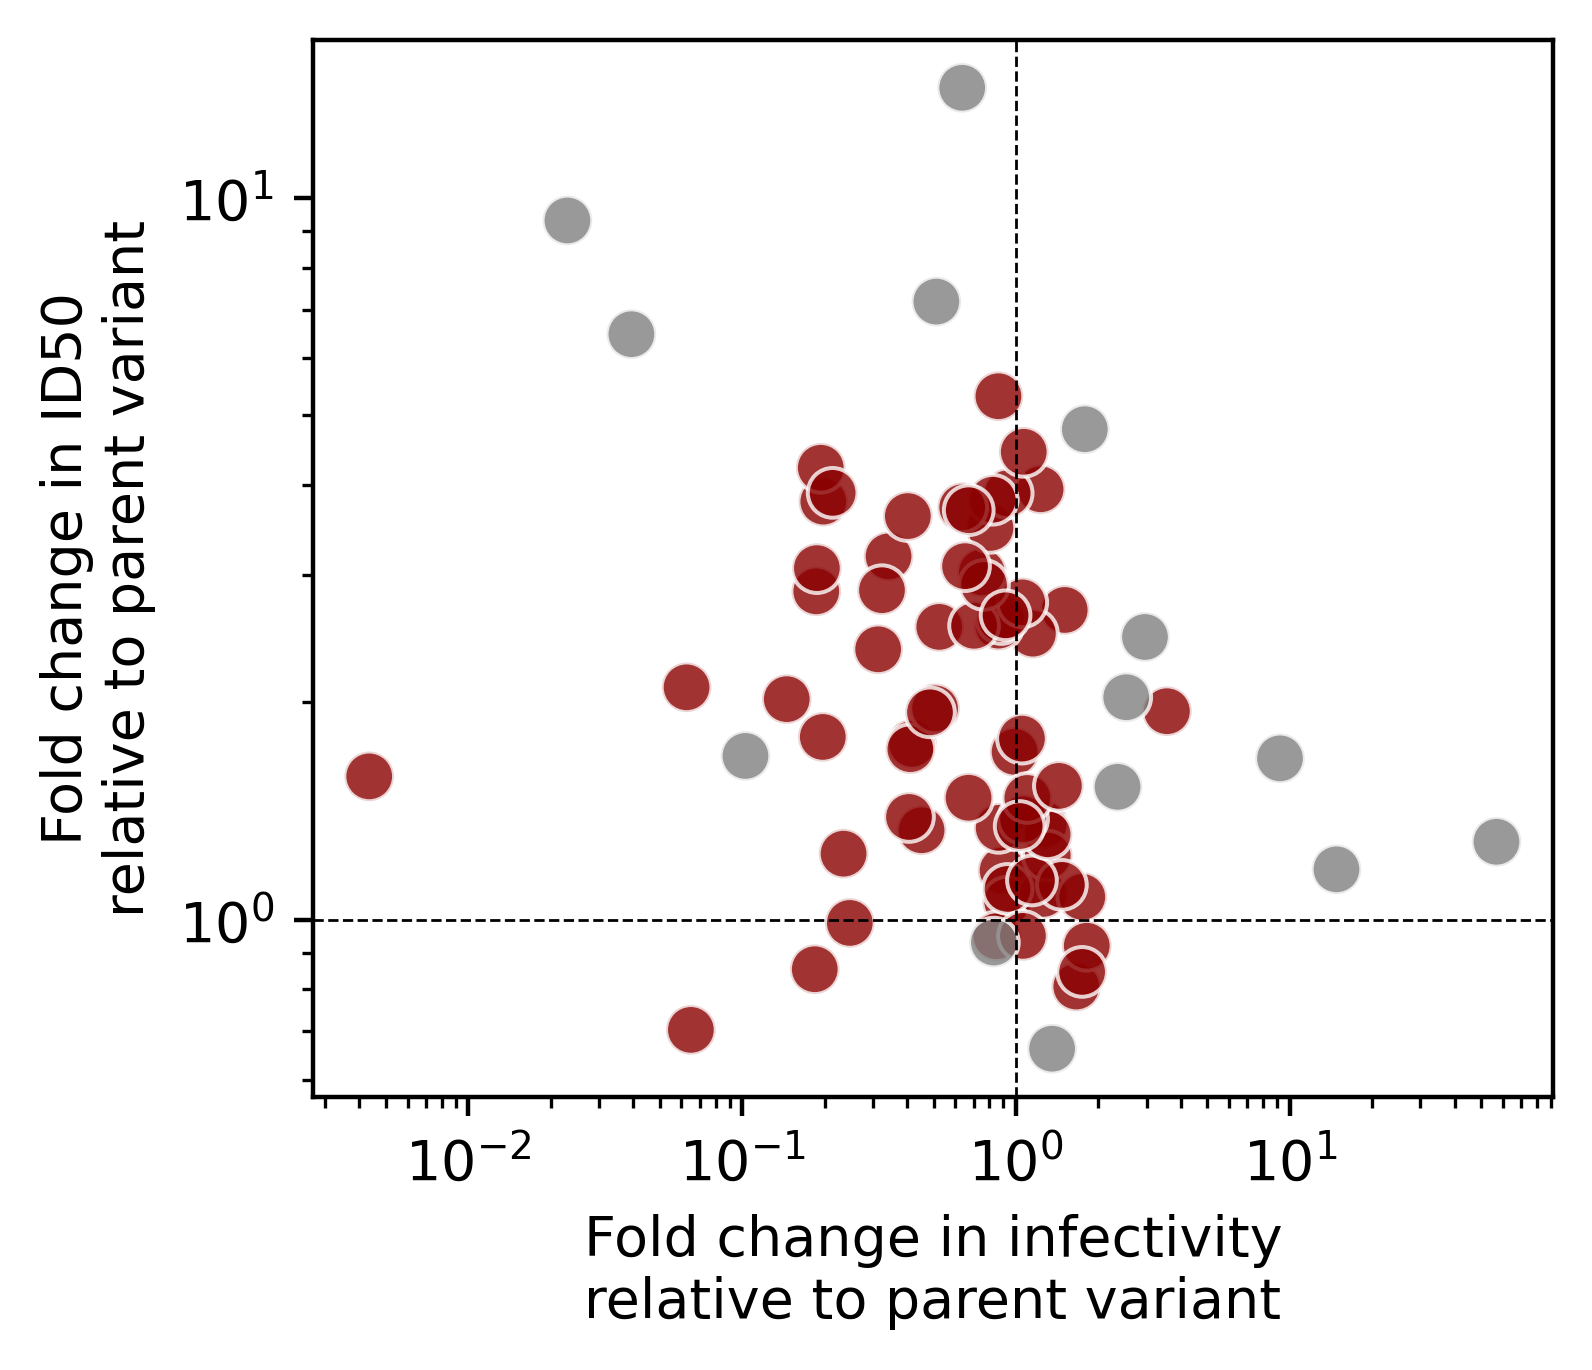

In [119]:
fig, ax = plt.subplots(1, 1, sharey = True, figsize = (4,3.5))


sns.scatterplot(x = "Infectivity relative to base VoC", y = "Fold Reduction", 
                hue = 'label', data = df_fin, alpha = 0.8, s = 80, 
               palette = {"des": "darkred", "const": "0.5"})

plt.yscale("log")
plt.xscale("log")

plt.legend([],[], frameon=False)

plt.axvline(1, linestyle = "--", color = 'k', linewidth = 0.5)
plt.axhline(1, linestyle = "--", color = 'k', linewidth = 0.5)


plt.ylabel("Fold change in ID50\nrelative to parent variant")
plt.xlabel("Fold change in infectivity\nrelative to parent variant")

plt.savefig('../Figures/Fig2b_inf_vs_neut.svg', format='svg')